In [1]:
%%capture
# ! pip install -q git+https://github.com/EfficientDL/codelab_utils.git
# !pip install tensorflow-model-optimization
import math, pickle

import tensorflow as tf
import tensorflow_datasets as tfds
# import tensorflow_models as tfm
import tensorflow_addons as tfa
import tensorflow_model_optimization as tfmot
import ipywidgets as ipyw
import numpy as np
import kerastuner as kt

from pathlib import Path
from tensorflow.keras import layers, optimizers, metrics, losses, models
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model, array_to_img
from matplotlib import pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

## Dataset Download

In [2]:
%%capture
# Dataset Configurations
IMG_SIZE = 96
N_CLASSES = 102

unlabelled_ds, labelled_ds, val_ds, test_ds = tfds.load(
    'oxford_flowers102',
    split=['train[:80%]', 'train[80%:]', 'validation', 'test'],
    as_supervised=True,
    read_config=tfds.ReadConfig(try_autocache=False)
)

def resize(image):
    return layers.Resizing(IMG_SIZE, IMG_SIZE)(image)

unlabelled_prep_ds = unlabelled_ds.map(lambda x,y: (resize(x), y))
labelled_prep_ds = labelled_ds.map(lambda x,y: (resize(x), y))

# train_ds, val_ds, test_ds = tfds.load(
#     'stl10',
#     split=['unlabelled[:20%]', 'train', 'test'],
#     as_supervised=True, with_info=False,
#     # read_config=tfds.ReadConfig(try_autocache=False),
# )

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-30 22:10:58.964376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-30 22:10:58.964485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Standardize Dataset

In [3]:
# Configuration for deterministic results
SEED = 3
tf.random.set_seed(SEED), np.random.seed(SEED)
# RAND_GENERATOR = tf.random.Generator.from_seed(SEED)

# Stronger augmentations for contrastive, weaker ones for supervised training
CONTRASTIVE_AUG_PARAMS = {"min_area": 0.08, "brightness": 0.6, "jitter": 0.2}
CLASSIFICATION_AUG_PARAMS = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

# Distorts the color distibutions of images
class RandomColorAugmentation(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config
    
    def color_distortion(self, image, factor=0.6):
        def color_jitter(x):
            x = tf.image.random_brightness(x, factor)
            x = tf.image.random_contrast(x, 1-factor, 1+factor)
            x = tf.image.random_saturation(x, 1-factor, 1+factor)
            x = tf.image.random_hue(x, self.jitter)
            return x

        x = color_jitter(image)

        return x

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]
            images = self.color_distortion(images)
            images = tf.clip_by_value(images, 0.0, 1.0)

        return images

# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAugmentation(brightness, jitter),
        ],
        name='augmenter'
    )

## Visualize Augmentations

2022-08-30 22:11:04.766902: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


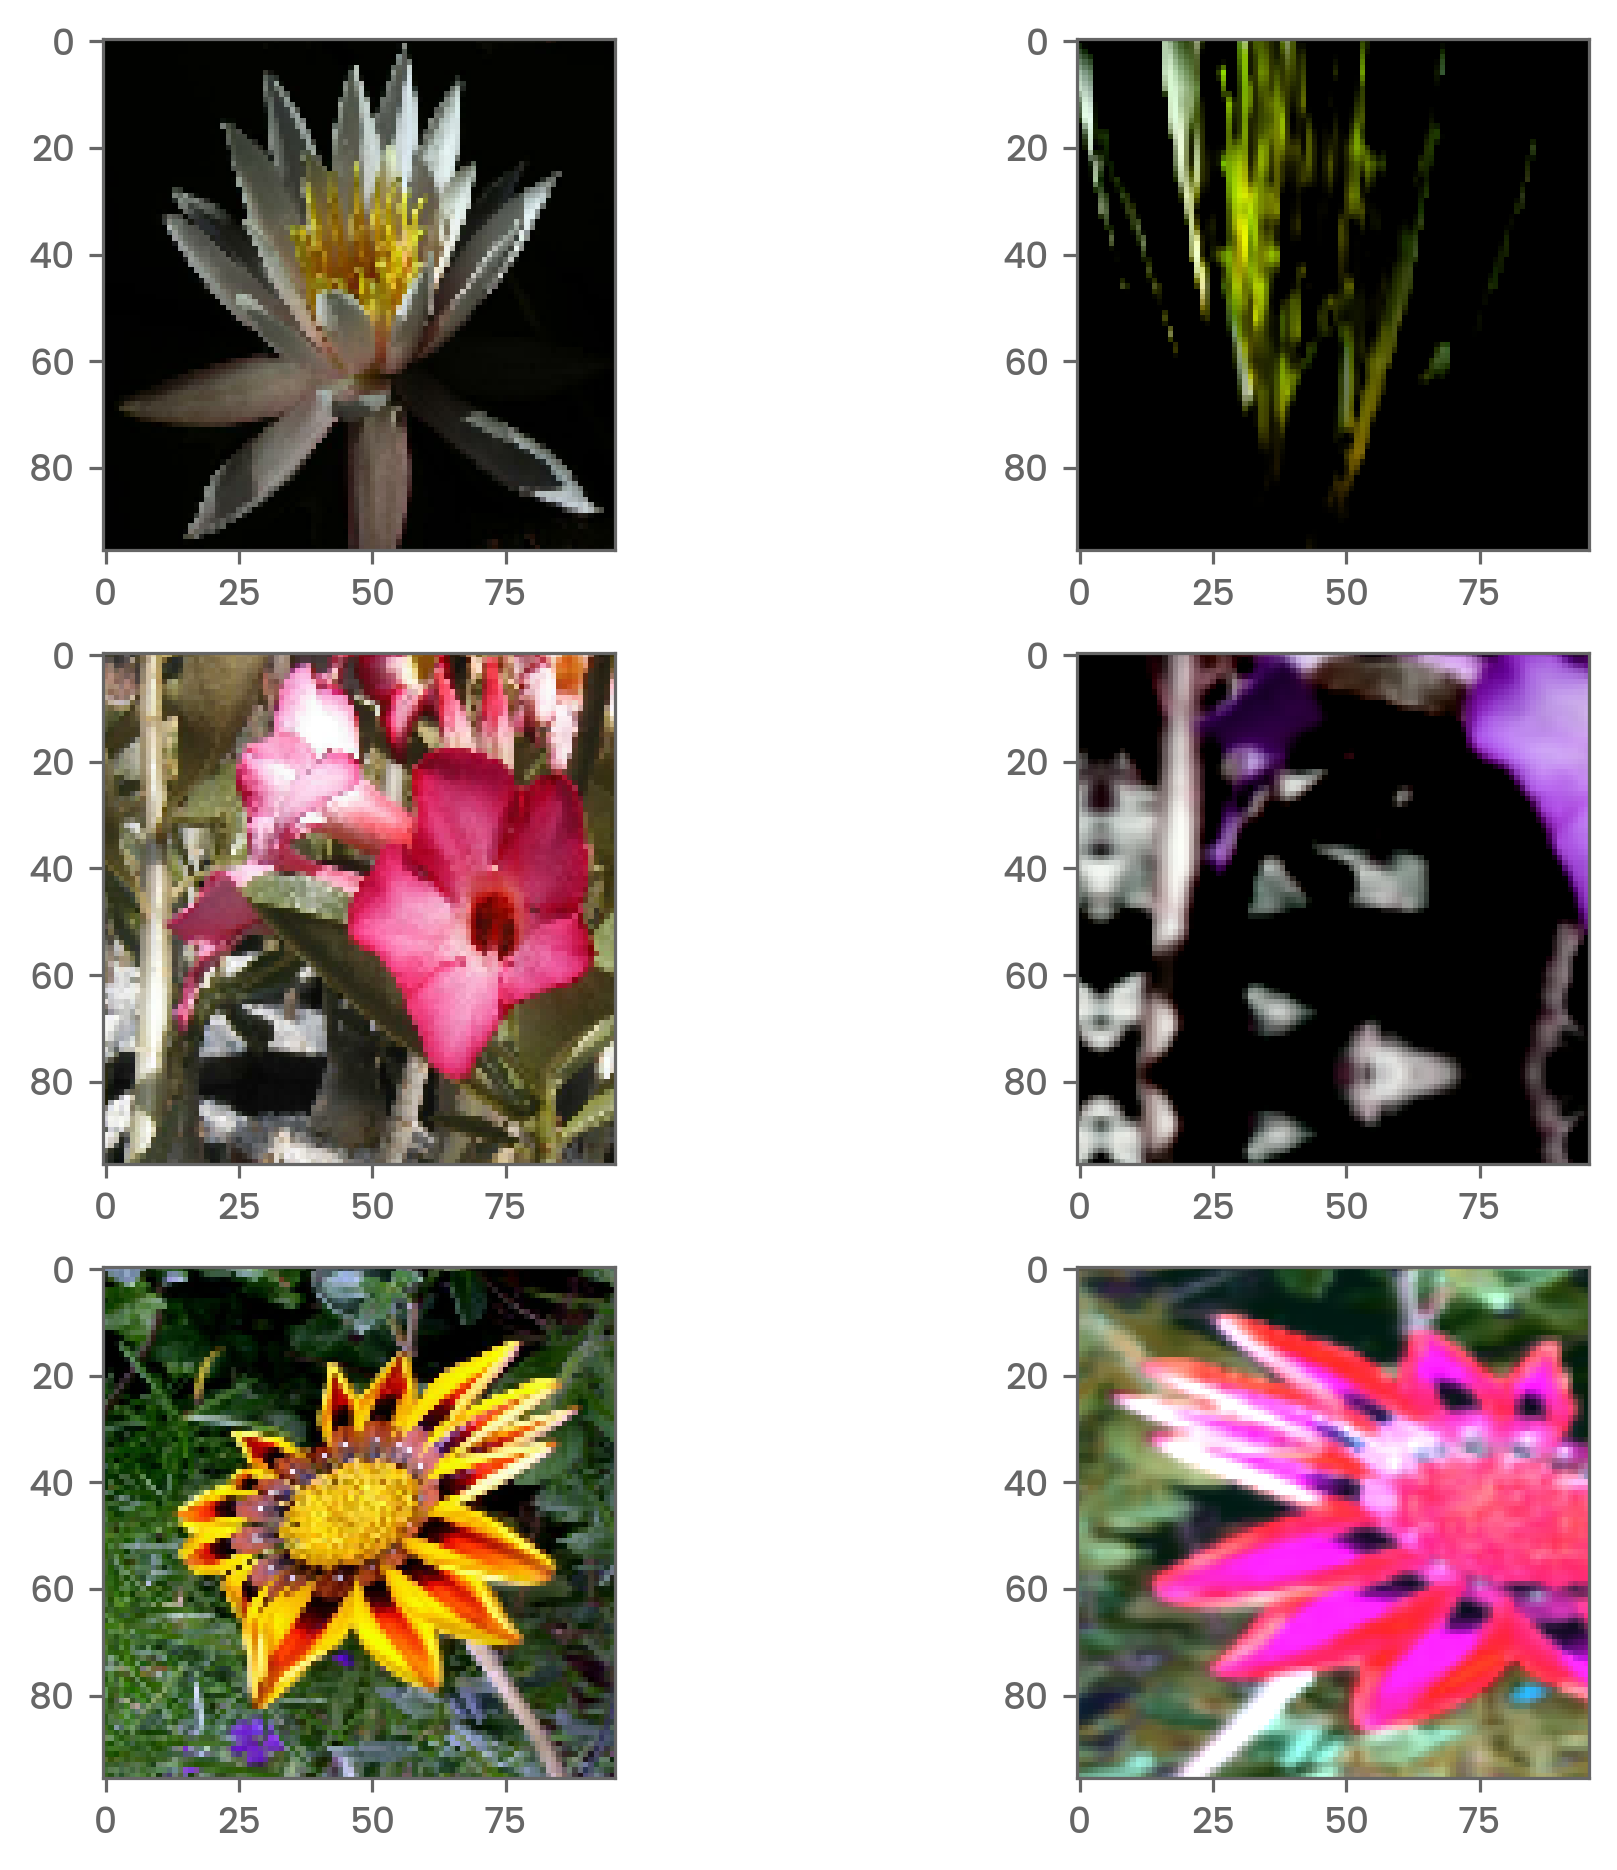

In [4]:
aug = get_augmenter(**CONTRASTIVE_AUG_PARAMS)
itr = unlabelled_ds.batch(1).as_numpy_iterator()

def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, image in enumerate(display_list):
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(image))

def apply_aug(image):
    resized = layers.Resizing(IMG_SIZE, IMG_SIZE)(image)
    return tf.squeeze(resized), tf.squeeze(aug(resized))

image1, _ = next(itr)
image2, _ = next(itr)
image3, _ = next(itr)
image1, aug1 = apply_aug(image1)
image2, aug2 = apply_aug(image2)
image3, aug3 = apply_aug(image3)

display([image1, aug1, image2, aug2, image3, aug3])

## Model Components

In [5]:
WIDTH = 256

def get_encoder(width=WIDTH):
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=1, activation="relu"),
            layers.GlobalMaxPool2D(),
            layers.Dense(width, activation="relu"),
        ],
        name='encoder'
    )

def get_projection_head(width=WIDTH):
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(width,)),
            layers.Dense(width, activation='relu'),
            layers.Dense(width)
        ],
        name='projection_head'
    )

encoder = get_encoder()
projection_head = get_projection_head()

encoder.summary()
projection_head.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 47, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 256)       590080    
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 256)       590080    
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 256)       590080    
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 256)         590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 256)         590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 256)         5900

## Contrastive Learning Model

In [7]:
# Training Hyper Parameters
LEARNING_RATE = 0.0002
TEMPERATURE = 0.1

class ContrastiveModel(tf.keras.Model):
    def __init__(self, temp=TEMPERATURE):
        super().__init__()
        self.temp = temp

        # Model Parts
        self.augmenter = get_augmenter(**CONTRASTIVE_AUG_PARAMS)
        self.encoder = get_encoder()
        self.projection_head = get_projection_head()

        # Update Config
        self.config = {'temp': TEMPERATURE}
    
    def get_config(self):
        return self.config

    def compile(self, contrastive_optimizer, **kwargs):
        super(ContrastiveModel, self).compile(**kwargs)

        # Optimizer
        self.contrastive_optimizer = contrastive_optimizer

        # Metrics
        self.contrastive_loss = tf.keras.metrics.Mean(name='loss')
        self.contrastive_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='acc')

    @property
    def metrics(self):
        return [self.contrastive_loss, self.contrastive_acc]
    
    def compute_projections(self, x, training=True):
        x = self.augmenter(x, training=training)
        x = self.encoder(x, training=training)
        x = self.projection_head(x, training=training)
        return x
    
    def compute_similarities(self, p1, p2):
        normalized1 = tf.math.l2_normalize(p1, axis=-1)
        normalized2 = tf.math.l2_normalize(p2, axis=-1)
        similarities = tf.matmul(normalized1, normalized2, transpose_b=True) / self.temp
        return similarities
    
    def compute_loss(self, p1, p2):
        batch_size = tf.shape(p1)[0]
        similarities = self.compute_similarities(p1, p2)
        contrastive_labels = tf.range(batch_size)

        loss_1 = losses.sparse_categorical_crossentropy(
            contrastive_labels,
            similarities,
            from_logits=True
        )
        loss_2 = losses.sparse_categorical_crossentropy(
            contrastive_labels,
            tf.transpose(similarities),
            from_logits=True
        )
        loss = loss_1 + loss_2

        # Update the loss and accuracy metrics
        self.contrastive_loss.update_state(loss)
        self.contrastive_acc.update_state(
            contrastive_labels,
            similarities
        )
        self.contrastive_acc.update_state(
            contrastive_labels,
            tf.transpose(similarities)
        )

        return loss

    @tf.function
    def train_step(self, batch):
        x, y = batch
        # tf.print(batch)
        # (x, y) = batch
        # x = batch
        batch_size = tf.shape(x)[0]
        with tf.GradientTape() as tape:
            projection1 = self.compute_projections(x)
            projection2 = self.compute_projections(x)
            loss = self.compute_loss(projection1, projection2)
        
        gradients = tape.gradient(
            loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights
            )
        )
        return {m.name: m.result() for m in self.metrics}
    
    @tf.function
    def test_step(self, x, y):
        batch_size = tf.shape(x)[0]
        projection1 = self.compute_projections(x, training=False)
        projection2 = self.compute_projections(x, training=False)
        loss = self.compute_loss(projection1, projection2)
        
        return {m.name: m.result() for m in self.metrics}

c_model = ContrastiveModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
c_model.compile(contrastive_optimizer=optimizer)
c_model.fit(unlabelled_prep_ds.batch(64), epochs=10)

Epoch 1/10


2022-08-30 22:12:33.845096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 21s 2s/step - loss: 7.2173 - acc: 0.1752
Epoch 2/10
13/13 [==============================] - 24s 2s/step - loss: 6.2637 - acc: 0.2457
Epoch 3/10
13/13 [==============================] - 18s 1s/step - loss: 5.7559 - acc: 0.2843
Epoch 4/10
13/13 [==============================] - 17s 1s/step - loss: 5.4679 - acc: 0.3321
Epoch 5/10
13/13 [==============================] - 17s 1s/step - loss: 5.2165 - acc: 0.3346
Epoch 6/10
13/13 [==============================] - 16s 1s/step - loss: 4.9336 - acc: 0.3450
Epoch 7/10
13/13 [==============================] - 16s 1s/step - loss: 4.8577 - acc: 0.3940
Epoch 8/10
13/13 [==============================] - 15s 1s/step - loss: 4.8345 - acc: 0.3885
Epoch 9/10
13/13 [==============================] - 15s 1s/step - loss: 4.7734 - acc: 0.3934
Epoch 10/10
13/13 [==============================] - 15s 1s/step - loss: 4.4753 - acc: 0.4240


In [10]:
c_model.fit(unlabelled_prep_ds.shuffle(500, reshuffle_each_iteration=True).batch(64), epochs=40)

Epoch 1/40
13/13 [==============================] - 17s 1s/step - loss: 3.2188 - acc: 0.5496
Epoch 2/40
13/13 [==============================] - 16s 1s/step - loss: 2.9961 - acc: 0.5931
Epoch 3/40
13/13 [==============================] - 16s 1s/step - loss: 2.9552 - acc: 0.5864
Epoch 4/40
13/13 [==============================] - 16s 1s/step - loss: 2.8552 - acc: 0.6017
Epoch 5/40
13/13 [==============================] - 16s 1s/step - loss: 3.0457 - acc: 0.5797
Epoch 6/40
13/13 [==============================] - 16s 1s/step - loss: 2.8339 - acc: 0.5974
Epoch 7/40
13/13 [==============================] - 16s 1s/step - loss: 2.8344 - acc: 0.5913
Epoch 8/40
13/13 [==============================] - 16s 1s/step - loss: 2.9952 - acc: 0.5790
Epoch 9/40
13/13 [==============================] - 16s 1s/step - loss: 2.9263 - acc: 0.5993
Epoch 10/40
13/13 [==============================] - 16s 1s/step - loss: 3.0909 - acc: 0.5790
Epoch 11/40
13/13 [==============================] - 15s 1s/step - lo

In [17]:
# c_model.save_weights('contrastive_learning_model.h5')


DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0002

def create_classification_model(core):
    # core.trainable = False

    model = tf.keras.Sequential([
        layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8),
        get_augmenter(**CLASSIFICATION_AUG_PARAMS),
        core,
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss='sparse_categorical_crossentropy'
    metrics=['accuracy']

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

classifier = create_classification_model(c_model.layers[1])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmenter (Sequential)      (None, 96, 96, 3)         0         
                                                                 
 encoder (Sequential)        (None, 256)               4203520   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 102)               26214     
                                                                 
Total params: 4,229,734
Trainable params: 4,229,734
Non-trainable params: 0
_________________________________________________________________


In [20]:
EPOCHS = 20

tds = unlabelled_prep_ds.shuffle(500, reshuffle_each_iteration=True).batch(64)
val_prep_ds = val_ds.map(lambda x,y: (resize(x), y))
vds = val_prep_ds.batch(128)

# Validation Dataset
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

classifier.fit(tds, validation_data=vds, epochs=EPOCHS, callbacks=[early_stopping])

# print('Saving the classifier model as:', CLASSIFIER_MODEL)
# classifier.save(CLASSIFIER_MODEL)
# classifier.evaluate(test_prep_ds.batch(256))

Epoch 1/20
13/13 [==============================] - 12s 923ms/step - loss: 4.5569 - accuracy: 0.0453 - val_loss: 4.4242 - val_accuracy: 0.0363
Epoch 2/20
13/13 [==============================] - 12s 896ms/step - loss: 4.3987 - accuracy: 0.0527 - val_loss: 4.3700 - val_accuracy: 0.0441
Epoch 3/20
13/13 [==============================] - 12s 897ms/step - loss: 4.2817 - accuracy: 0.0527 - val_loss: 4.3608 - val_accuracy: 0.0510
Epoch 4/20
13/13 [==============================] - 12s 883ms/step - loss: 4.1496 - accuracy: 0.0686 - val_loss: 4.3334 - val_accuracy: 0.0569
Epoch 5/20
13/13 [==============================] - 12s 886ms/step - loss: 4.0254 - accuracy: 0.0735 - val_loss: 4.4269 - val_accuracy: 0.0500
Epoch 6/20
13/13 [==============================] - 12s 895ms/step - loss: 3.9398 - accuracy: 0.0858 - val_loss: 4.1960 - val_accuracy: 0.0608
Epoch 7/20
13/13 [==============================] - 12s 919ms/step - loss: 3.7481 - accuracy: 0.0931 - val_loss: 4.2724 - val_accuracy: 0.0647

In [81]:
from base64 import encode

def get_loss_fn(TEMP=TEMPERATURE):
    def nt_xent_loss(_, z):
        N = tf.shape(z)[0]//2
        similarity = tf.keras.losses.CosineSimilarity(-1, tf.keras.losses.Reduction.NONE)

        def exp_similarity(i, j):
            return tf.math.exp(similarity(z[i], z[j]) / TEMP)

        def item_loss(i, j):
            positive_loss = exp_similarity(i, j)
            negative_loss = 0.0

            for k in range(2*N):
                if k == i: continue
                negative_loss += exp_similarity(i, k)
            
            loss = -tf.math.log(positive_loss/negative_loss)
            return loss
            
        loss = 0.0
        for p in range(N):
            loss += (item_loss(2*p, 2*p+1) + item_loss(2*p+1, 2*p))

        normalized_loss = loss/(2.0*tf.cast(N, dtype=tf.float32))
        return normalized_loss
    return nt_xent_loss

def create_contrastive_learning_model(hp=None):
    # HyperParameters
    # LR = hp.Choice('lr', values = [1e-2, 1e-3, 1e-4]) if hp else LEARNING_RATE
    # TEMP = hp.Choice('temperature', values = [.05, .1, .4]) if hp else TEMPERATURE
    LR = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log") if hp else LEARNING_RATE
    TEMP = hp.Float("temperature", min_value=.05, max_value=.4, sampling="log") if hp else TEMPERATURE

    

    model = tf.keras.Sequential([
      tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
      augmenter,
      encoder,
      projection_head
    ])

    adam = optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=adam, loss=get_loss_fn(TEMP))
    
    return model

cl_model = create_contrastive_learning_model()
cl_model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmenter (Sequential)      (None, 264, 264, 3)       0         
                                                                 
 encoder (Sequential)        (None, 256)               4203520   
                                                                 
 projection_head (Sequential  (None, 256)              131584    
 )                                                               
                                                                 
Total params: 4,335,104
Trainable params: 4,335,104
Non-trainable params: 0
_________________________________________________________________


## APIs to plot training metrics

In [136]:
def plot_loss(h):
    fig = plt.figure()
    ax = fig.gca()

    ax.plot(h['loss'], label='Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Losses')

    ax.legend()

## Contrastive Model HyperParameter Search

In [ ]:
# # BATCH_SIZE = 24
# # EPOCHS = 30
# BATCH_SIZE = 8
# EPOCHS = 3

# print('Searching hyper-parameters for the contrastive model')
# tds = train_contrastive_ds.batch(BATCH_SIZE)
# tuner = kt.RandomSearch(
#     create_contrastive_learning_model,
#     objective = 'loss', 
#     max_trials = 5,
#     directory = 'random_search_starter',
#     project_name = 'simclr'
# )
# tuner.search(tds, epochs=EPOCHS)

# best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
# print('Best hyperparameters', best_hyperparameters.values)

## Train the contrastive model

In [163]:
# BATCH_SIZE = 24
# EPOCHS = 30
BATCH_SIZE = 2
EPOCHS = 2
CONTRASTIVE_LEARNING_MODEL = 'contrastive_learning_model.h5'

# if not Path(CONTRASTIVE_LEARNING_MODEL).exists():
#     ! wget "https://www.dropbox.com/s/bbv4dakqg45ctty/contrastive_learning_model.h5?dl=1" -O $CONTRASTIVE_LEARNING_MODEL

#     print('Loading the pre-trained contrastive learning model...')
#     cl_model.load_weights(CONTRASTIVE_LEARNING_MODEL)

print('Training the contrastive learning model')
tds = train_contrastive_ds.batch(BATCH_SIZE).take(10)
hist = cl_model.fit(tds, epochs=EPOCHS)
plot_loss(hist.history), print(hist.history)

print('Saving the constrastive learning model as:', CONTRASTIVE_LEARNING_MODEL)
cl_model.save_weights(CONTRASTIVE_LEARNING_MODEL)

Training the contrastive learning model
0.01 0.05
None
Best hyperparameters {'lr': 0.001, 'temperature': 0.1}
Saving the constrastive learning model as: contrastive_learning_model.h5
0.001 0.1


## Classification model

In [173]:
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0002

def create_classification_model(core):
    core.trainable = False

    inp = layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8)
    head = tf.keras.Sequential([
            layers.Dropout(DROPOUT_RATE),
            layers.Dense(N_CLASSES, activation='softmax')
        ],
        name='classification_head')

    features = core(inp)
    output = head(features)

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss='sparse_categorical_crossentropy'
    metrics=['accuracy']

    model = tf.keras.Model(inputs=[inp], outputs=output)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

classifier = create_classification_model(cl_model.layers[1])
classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 264, 264, 3)]     0         
                                                                 
 features (Sequential)       (None, 2048)              23587712  
                                                                 
 classification_head (Sequen  (None, 102)              208998    
 tial)                                                           
                                                                 
Total params: 23,796,710
Trainable params: 208,998
Non-trainable params: 23,587,712
_________________________________________________________________


## Train the classifier

In [ ]:
# BATCH_SIZE = 24
# EPOCHS = 10
BATCH_SIZE = 2
EPOCHS = 1

def apply_augmentations_for_classification(image):
    def random_flip(x):
        return tf.image.random_flip_left_right(x)

    image = random_crop_and_resize(image)
    image = random_flip(image)
    return image

def make_classification_input(image, label):
    image = apply_augmentations_for_classification(image)
    return image, label

# tds = train_prep_ds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).take(1)
# vds = val_prep_ds.batch(256).cache().take(1)
# Training Dataset
tds = train_prep_ds.map(make_classification_input, num_parallel_calls=tf.data.AUTOTUNE)
tds = tds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).take(1)

# Validation Dataset
vds = val_prep_ds.batch(256).cache().take(1)

In [142]:

CLASSIFIER_MODEL = 'classifier_model.h5'

# Save the best weights during training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

classifier.fit(tds, validation_data=vds, epochs=EPOCHS, callbacks=[early_stopping])

print('Saving the classifier model as:', CLASSIFIER_MODEL)
classifier.save(CLASSIFIER_MODEL)
classifier.evaluate(test_prep_ds.batch(256))

2022-08-16 20:34:04.168897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 4.1454 - accuracy: 0.0000e+00

2022-08-16 20:34:08.658284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-16 20:34:21.161515: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 29s 29s/step - loss: 4.1454 - accuracy: 0.0000e+00 - val_loss: 5.5977 - val_accuracy: 0.0195
Saving the classifier model as: classifier_model.h5
 5/25 [=====>........................] - ETA: 2:58 - loss: 5.4489 - accuracy: 0.0281

KeyboardInterrupt: 